In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import argparse
import csv
import json
import time
import types, copy, pprint
import logging 
import shutil
import sys
import getpass
from datetime import datetime

if './src' not in sys.path:
    print(f"insert ./src")
    sys.path.insert(0, './src')
print(sys.path)

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import torch
import torch.nn.functional as F
from torchinfo import summary
import matplotlib.pyplot as plt

from tqdm import tqdm
print(torch.__version__)

pd.options.display.width = 132
pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# print("1- '%x_%X'               : ",time.strftime('%x_%X'))
# print("2- '%X.%f'               : ",datetime.now().strftime('%X.%f'))
# print("3- '%X %x %Z'            : ",time.strftime('%X %x %Z'))
# print("4- '%D-%X.%f'            : ",datetime.now().strftime('%D-%X.%f'))
# print("5- '%Y-%m-%d %H:%M:%S.%f': ",datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'))
# print("6- '%Y%m%d_%H%M%S'       : ",datetime.now().strftime('%Y%m%d_%H%M%S'))
# print("7- '%Y_%m_%d_%H:%M:%S'   : ",datetime.now().strftime('%Y_%m_%d_%H:%M:%S'))

timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print(' Timestamp: ','./tmp/sql_cohort'+'_'+timestamp+'.txt')

logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

insert ./src
['./src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']
2.2.1+cu118
 Timestamp:  ./tmp/sql_cohort_2024_04_05_06:44:42.txt


In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sb

In [4]:
def _get_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = f"{device}:{torch.cuda.current_device()}"
    print("Running on:", device, torch.cuda.get_device_name(), torch.cuda.current_device())
    return device

current_device = _get_device()
print(f"Current device is : {current_device}")

Running on: cuda:0 Quadro GV100 0
Current device is : cuda:0


# Setup

In [5]:
# Soft Nearest Neighbor Loss
# Copyright (C) 2020  Abien Fred Agarap
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""Sample module for using DNN classifier with SNNL"""
import argparse

import torch
# from pt_datasets import create_dataloader, load_dataset
# from pt_datasets import display_cellpainting_batch
# from snnl.models import DNN
from snnl.utils import export_results, get_hyperparameters, set_global_seed
from snnl.utils.metrics import accuracy
from snnl.utils import save_model

__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"

'Sample module for using DNN classifier with SNNL'

In [6]:
from dev_code import Model, DNN, Autoencoder, SNNLoss
from dev_code import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn, parse_args

In [7]:
def parse_args(input = None):
    parser = argparse.ArgumentParser(description="DNN classifier with SNNL")
    group = parser.add_argument_group("Parameters")
    group.add_argument(
        "-s",
        "--seed",
        required=False,
        default=1234,
        type=int,
        help="the random seed value to use, default: [1234]",
    )
    group.add_argument(
        "-m",
        "--model",
        required=False,
        default="baseline",
        type=str,
        help="the model to use, options: [baseline (default) | snnl]",
    )
    group.add_argument(
        "-c",
        "--configuration",
        required=False,
        default="examples/hyperparameters/dnn.json",
        type=str,
        help="the path to the JSON file containing the hyperparameters to use",
    )
    arguments = parser.parse_args(input)
    return arguments

In [8]:
# if __name__ == "__main__":
input_args = f" --seed              1234 " \
             f" --model             snnl" \
             f" --configuration     examples/hyperparameters/dnn_cellpainting.json"
             # f" --configuration     examples/hyperparameters/dnn_mnist.json"
             # f" --model             baseline" \
args = parse_args(input_args.split())

args

Namespace(seed=1234, model='snnl', configuration='examples/hyperparameters/dnn_cellpainting.json')

In [9]:
set_global_seed(args.seed)

#### main(args)

In [10]:
# DNN
(   
    dataset,
    batch_size,
    epochs,
    learning_rate,
    units,
    snnl_factor,
    temperature,
    cellpainting_args
 ) = get_hyperparameters(args.configuration)


hello common cellpainting 
hello dnn 
hello dnn_cellpainting 


In [11]:
# dataset = 'cellpainting'
# units = [[1471, 1024], [1024, 1024], [1024, 512], [512,32] ]
# epochs = 10
batch_size = 1
learning_rate = 0.001

In [70]:
if dataset == "cellpainting": 
    cellpainting_args['batch_size']  = batch_size
    cellpainting_args['dataset_path'] = '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1471_HashOrder.csv'
    # cellpainting_ds = dict()
    cellpainting_args['train_start'] = 0
    cellpainting_args['train_end']   = 1200
    cellpainting_args['compounds_per_batch']   = 100
    # cellpainting_args['sample_size'] = 3
    # cellpainting_args['test_start']  = 300000
    # cellpainting_args['test_end']    = cellpainting_ds['test_start'] + 3333  ## 346542
    # cellpainting_args['chunksize']   = None
    # cellpainting_args['conversions'] = None
    # cellpainting_args['iterator'] = True

In [71]:
file_sz = cellpainting_args['train_end'] - cellpainting_args['train_start']
smp_sz = cellpainting_args['sample_size']
buf_sz = cellpainting_args['compounds_per_batch']
batch_size = 1
bth_sz = batch_size

recs_per_batch = smp_sz * bth_sz * buf_sz
bth_per_epoch = file_sz // recs_per_batch
print(f" - Each batch contains {recs_per_batch/smp_sz} compounds, {smp_sz} samples per each compound : total {recs_per_batch} rows")
print(f" - Number of {recs_per_batch} row full size batches per epoch: {bth_per_epoch}")
print(f" - Rows covered by {bth_per_epoch} full size batches ({recs_per_batch} rows) per epoch:  {(file_sz // recs_per_batch) * recs_per_batch}")
print(f" - Last batch contains : {file_sz % recs_per_batch} rows")
 

 - Each batch contains 100.0 compounds, 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 4
 - Rows covered by 4 full size batches (300 rows) per epoch:  1200
 - Last batch contains : 0 rows


In [72]:
# print(f"   code_dim          {code_dim}")
print(f"   dataset           {dataset}")
print(f"   batch_size        {batch_size}")
print(f"   epochs            {epochs}")
print(f"   learning_rate     {learning_rate}")
print(f"   units             {units}")
print(f"   snnl_factor       {snnl_factor}")
print(f"   temperature       {temperature}")
if dataset == "cellpainting": 
    pp.pprint(cellpainting_args)

   dataset           cellpainting
   batch_size        1
   epochs            10
   learning_rate     0.001
   units             [[1471, 1024], [1024, 1024], [1024, 512], [512, 128], [128, 128]]
   snnl_factor       10.0
   temperature       50.0
{   'batch_size': 1,
    'chunksize': None,
    'compounds_per_batch': 100,
    'conversions': None,
    'dataset_path': '/home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1471_HashOrder.csv',
    'iterator': True,
    'sample_size': 3,
    'test_end': 310000,
    'test_start': 300000,
    'train_end': 1200,
    'train_start': 0}


### Define dataset and dataloaders

In [73]:
   #### Load CellPainting Dataset
if dataset == 'cellpainting':
    print(f" load {dataset}")
    train_dataset = CellpaintingDataset(train = True,    **cellpainting_args)
    train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size=1,shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
    
    # train_dataset, test_dataset = load_dataset(name='cellpainting', cellpainting_args = cellpainting_args)
    # test_loader = create_dataloader(dataset=test_dataset, batch_size=batch_size, shuffle = False, num_workers = 0 , collate_fn = custom_collate_fn)
    # train_dataloader = DataLoader(dataset = train_dataset, batch_size=10, num_workers = 0, collate_fn=custom_collate, worker_init_fn = worker_init_fn, shuffle= False)
    # test_dataloader  = DataLoader(dataset = test_dataset , batch_size=12, num_workers = 0, collate_fn=custom_collate, worker_init_fn = worker_init_fn, shuffle= False)

 load cellpainting


In [74]:
# test_batch_id = 0
# for idx, batch in enumerate(train_loader):
#     print(idx, batch[0].shape, batch[1].shape,batch[2].shape,batch[3].shape,batch[4].shape)
#     train_batch_id +=1
    ### print(batch[1])
    ### print(batch[2])
    # display_cellpainting_batch(train_batch_id, batch)
    # if train_batch_id ==3 :
    #     break
    # if idx >= 2:
    #     break
    # break

### Define DNN Model

In [34]:
if args.model.lower() == "baseline":
    print(f" baseline model")
    model = DNN(units=units, learning_rate=learning_rate)
    
elif args.model.lower() == "snnl":
    print(f" snnl model")
    model = DNN(
        units=units,
        learning_rate=learning_rate,
        use_snnl=True,
        factor=snnl_factor,
        temperature=temperature,
        use_annealing=False,
        unsupervised = True,
        sample_size = cellpainting_args['sample_size']
    )
else:
    raise ValueError("Choose between [baseline] and [snnl] only.")

model.device
model.optimizer
# model.optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
# model.optimizer
# model.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.5, patience=25, 
                                                             # threshold=0.0001, threshold_mode='rel', cooldown=5, 
                                                             # min_lr=0, eps=1e-08)
# model.scheduler.get_last_lr()

 snnl model
 Building Base Model from NOTEBOOK
    Model_init()_    -- Crtierion  :       CrossEntropyLoss()
    Model_init()_    -- temperature :      50.0
    Model_init()_    -- temperature LR:    0.001
    Model_init()_    -- mode:              classifier
    Model_init()_    -- unsupervised :     True
    Model_init()_    -- use_snnl :         True
 Build SNNLoss dfrom NOTEBOOK
 Building SNNLoss from NOTEBOOK
    SNNLoss _init()_    -- mode: classifier was found in SNNLoss._supported_modes --   is unsupervised: False
    SNNLoss _init()_    -- primary_criterion: CrossEntropyLoss()
    SNNLoss _init()_    -- unsupervised :     True
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      3
    Model_init()_    -- temperature :      Parameter containing:
tensor([50.], requires_grad=True)
 Building DNN from NOTEBOOK
    DNN _init()_    -- mode:              classifier
    DNN _init()_    -- unsupervised :     True
    DNN _init()_    -- use_sn

device(type='cuda', index=0)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

#### Display model summary

In [36]:
col_names = [ "input_size",
                "output_size",
                "num_params",
                "params_percent",
                # "kernel_size",
                "mult_adds",
                "trainable"]
summary_input_size = (batch_size * cellpainting_args['sample_size'], 1471)
summary(model, input_size=summary_input_size, col_names = col_names)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
DNN                                      [3, 1471]                 [3, 128]                  1                           0.00%                   --                        True
├─ModuleList: 1-1                        --                        --                        --                             --                   --                        True
│    └─Linear: 2-1                       [3, 1471]                 [3, 1024]                 1,507,328                  47.64%                   4,521,984                 True
│    └─Linear: 2-2                       [3, 1024]                 [3, 1024]                 1,049,600                  33.17%                   3,148,800                 True
│    └─Linear: 2-3                       [3, 1024]                 [3, 512]                  524,800               

In [31]:
# for index, layer in enumerate(model.layers):
#     print(f" {index}:  ")
#     print(layer)
#     if isinstance(layer, torch.nn.Linear):
#         print(layer.weight.shape)
# batch = next(test_loader)
# print(batch[0].shape, batch[1].shape,batch[2].shape,batch[3].shape,batch[4].shape)
# features = batch[0].view(batch[0].shape[0], -1)
# features.shape

In [38]:
activations = {}
for index, layer in enumerate(model.layers):
    # print(f" layer {index}    {layer}")  
    if index == 0:
        print(f"a- layer {index} activations[{index}] : Relu(layer[{index}])   Input: {layer.in_features}   out: {layer.out_features}")   
    elif index == len(model.layers) - 1:
        print(f"c- layer {index} activations[{index}] : Layer[{index}](activations[{index-1}])     Input: {layer.in_features}   out: {layer.out_features}")   
    else:
        print(f"b- layer {index} activations[{index}] : Relu(Layer[{index}](activations[{index-1}]))   Input: {layer.in_features}   out: {layer.out_features}")   
# logits = activations.get(len(activations) - 1)

a- layer 0 activations[0] : Relu(layer[0])   Input: 1471   out: 1024
b- layer 1 activations[1] : Relu(Layer[1](activations[0]))   Input: 1024   out: 1024
b- layer 2 activations[2] : Relu(Layer[2](activations[1]))   Input: 1024   out: 512
b- layer 3 activations[3] : Relu(Layer[3](activations[2]))   Input: 512   out: 128
c- layer 4 activations[4] : Layer[4](activations[3])     Input: 128   out: 128


# Prediction

In [38]:
del _load_previous_state

In [97]:
from snnl.utils import load_model, _load_previous_state
# fn = "DNN_snnl_withstatictemp_epoch400_2024_04_01_073006.pt"
fn = "DNN_snnl_lrn_temp_epoch_250_cpb_20_2024_04_02_173536.pt"
fn = "DNN_snnl_lrn_temp_epoch_25_cpb_100_clippedgrad_inversetemp_2024_04_05_075625.pt"
model, next_epoch = _load_previous_state(model, fn)

dict_keys(['epoch', 'state_dict', 'optimizer_state_dict'])
Loaded from checkpoint {'epoch': 25, 'state_dict': OrderedDict([('temperature', tensor([8.7474], device='cuda:0')), ('snnl_criterion.temperature', tensor([8.7474], device='cuda:0')), ('layers.0.weight', tensor([[-0.1238,  0.0378, -0.0859,  ...,  0.0266,  0.0052,  0.0510],
        [-0.0156,  0.0330,  0.0488,  ...,  0.0221,  0.0913, -0.0303],
        [-0.0206,  0.0980,  0.0839,  ...,  0.0906, -0.0165,  0.0907],
        ...,
        [ 0.1281, -0.0613,  0.0793,  ..., -0.0578, -0.1082, -0.0409],
        [-0.0179,  0.0276, -0.0259,  ..., -0.0780, -0.1298, -0.0759],
        [ 0.0008,  0.0186,  0.0505,  ...,  0.0092,  0.0941, -0.1576]], device='cuda:0')), ('layers.0.bias', tensor([-0.0756, -0.4139,  0.0780,  ...,  0.8070,  0.6881,  0.0984], device='cuda:0')), ('layers.1.weight', tensor([[-0.0174,  0.1930,  0.0602,  ..., -0.2052,  0.0644, -0.1521],
        [ 0.2066,  0.1017, -0.0533,  ...,  0.0247,  0.0336,  0.0507],
        [ 0.0138, -

In [98]:
next_epoch

26

In [99]:
model.eval()
model = model.cpu()

DNN(
  (primary_criterion): CrossEntropyLoss()
  (snnl_criterion): SNNLoss(
    (primary_criterion): CrossEntropyLoss()
  )
  (layers): ModuleList(
    (0): Linear(in_features=1471, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
)

## Run samples through model

In [100]:
# del embeddings, outputs
embeddings = {} #  np.empty((0,128))
for i in range(5):
    embeddings[i] = np.empty((0,activations[i].shape[1]))
    print(embeddings[i].shape)
labels = np.empty((0))

(0, 1024)
(0, 1024)
(0, 512)
(0, 128)
(0, 128)


In [101]:
for idx, batch in enumerate(train_loader):
    # (batch_features, batch_labels, plate_well, compound, hash) 
    print(idx, batch[0].shape, batch[1].shape,batch[2].shape,batch[3].shape,batch[4].shape)
    batch[0][0:4,:10]
    # batch[2][0]
    # batch[3][0]
    # batch[4][0]
    out_activations =  model.predict(batch[0])
    type(out_activations), out_activations[0].shape,out_activations[1].shape,out_activations[2].shape,out_activations[3].shape, out_activations[4].shape
    # activations[4][0:5,:10]
    for k,v in out_activations.items():
        embeddings[k] = np.concatenate((embeddings[k], v.detach().numpy()))
    labels = np.concatenate((labels, batch[1]))
    # embeddings.shape, labels.shape


0 torch.Size([300, 1471]) torch.Size([300]) (300, 4) (300,) (300, 2)


tensor([[-0.4223, -0.4150,  0.2968,  0.3525, -0.0980,  0.6844,  0.0879,  0.3148,  0.3685,  0.5573],
        [-0.6346, -0.6232, -1.6046,  1.5566,  1.2294,  0.9913, -2.1594, -0.2223, -1.8072, -1.5103],
        [ 0.5108,  0.5563, -0.2246,  0.0649, -0.3265, -0.0918, -0.2892, -0.2770, -0.4397, -0.3035],
        [-1.8321, -1.8295,  1.0577, -0.1937, -0.4854, -1.9873,  0.5167, -0.3060, -0.0545, -0.0826]])

(dict,
 torch.Size([300, 1024]),
 torch.Size([300, 1024]),
 torch.Size([300, 512]),
 torch.Size([300, 128]),
 torch.Size([300, 128]))

1 torch.Size([300, 1471]) torch.Size([300]) (300, 4) (300,) (300, 2)


tensor([[ 0.1947,  0.2037,  0.7519,  0.2673, -0.0356, -0.4041, -0.7951, -0.0185, -0.2590, -0.0439],
        [-1.1471, -1.4927,  1.8544,  0.2696,  1.6389, -0.5774, -1.4927,  0.3315,  0.2438,  0.1175],
        [ 1.8228,  1.8697,  0.7194, -0.4349, -0.1745,  0.0996,  0.6293, -0.1325,  0.0823, -0.0264],
        [ 0.1350, -0.0482, -0.1947, -1.0408, -0.3678, -0.4881,  1.9925,  1.1695,  1.9704,  1.4834]])

(dict,
 torch.Size([300, 1024]),
 torch.Size([300, 1024]),
 torch.Size([300, 512]),
 torch.Size([300, 128]),
 torch.Size([300, 128]))

2 torch.Size([300, 1471]) torch.Size([300]) (300, 4) (300,) (300, 2)


tensor([[ 0.1436, -0.0054, -0.1615,  1.6530,  0.9957, -0.1660, -2.0972,  0.2850, -0.0707,  0.1336],
        [-0.7274, -0.7285, -0.5811, -0.0904, -1.6961, -1.1460,  0.2835, -0.4712,  0.4159,  0.0808],
        [-1.5612, -1.5354,  0.1882, -0.0332,  0.9564,  1.7110, -0.4419, -0.1750, -0.6373, -0.8089],
        [ 0.3000,  0.2903,  3.2479,  0.0530, -0.7512,  0.0037,  0.0407, -0.1022, -0.0396,  0.1967]])

(dict,
 torch.Size([300, 1024]),
 torch.Size([300, 1024]),
 torch.Size([300, 512]),
 torch.Size([300, 128]),
 torch.Size([300, 128]))

3 torch.Size([300, 1471]) torch.Size([300]) (300, 4) (300,) (300, 2)


tensor([[ 0.1546,  0.2968, -0.2971, -0.4982, -0.1389,  0.3294, -0.2251, -1.0040, -1.0977, -1.2058],
        [ 1.0594,  1.0195, -0.6777,  0.3276,  0.9616,  1.2611, -0.9565,  0.5496,  0.3683,  0.2461],
        [-0.7790, -0.6228,  1.2950,  0.3986,  0.4269,  1.6930, -0.2395, -0.8981, -1.9398, -1.4733],
        [-0.1657, -0.0369, -0.3605, -0.1708, -0.1171,  0.1789, -0.3326, -0.2138, -0.3055, -0.2301]])

(dict,
 torch.Size([300, 1024]),
 torch.Size([300, 1024]),
 torch.Size([300, 512]),
 torch.Size([300, 128]),
 torch.Size([300, 128]))

In [102]:
for i in range(5):
    print(embeddings[i].shape)

(1200, 1024)
(1200, 1024)
(1200, 512)
(1200, 128)
(1200, 128)


In [73]:
# type(activations)
# for key, act in activations.items():
#     print(key, type(act) , act.shape)
# print(type(logits), logits.shape)

In [ ]:
# activations[4][0:5,:10]
# embeddings = torch.cat((embeddings, activations[4]))

# embeddings[0:5, :10]

In [ ]:
model.test_accuracy = accuracy(y_true=test_dataset.targets, y_pred=predictions)

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
filename = f"DNN-{args.model.lower()}-{args.seed}.json"
export_results(model=model, filename=filename)

# PCA and TSNE


### define PCA model

In [25]:
loader_iter = iter(train_loader)

In [26]:
(batch_features, batch_labels, batch_plates, batch_compounds, batch_hash) = next(loader_iter)

In [27]:
type(batch_features), batch_features.shape, batch_labels.numpy().shape

(torch.Tensor, torch.Size([60000, 1471]), (60000,))

In [61]:
pca = PCA(n_components=200, copy=False, whiten=False, 
          svd_solver='auto', tol=0.0, iterated_power='auto', 
          n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

In [62]:
pca.fit(batch_features)
X = pca.transform(batch_features)

PCA(copy=False, n_components=200)

### define TSNE 

In [ ]:
tsne = TSNE()

projection = tsne.fit_transform(X)

projection.shape

In [ ]:
rows = 1000
df = pd.DataFrame(dict(
    x=projection[:rows,0],
    y=projection[:rows,1],
    label=batch_labels.numpy()[:rows]
    # moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    # batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    # compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    # correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    # level=pd.concat([treated_wells["level"],treatments["level"]])
))

df.info()
df.head()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

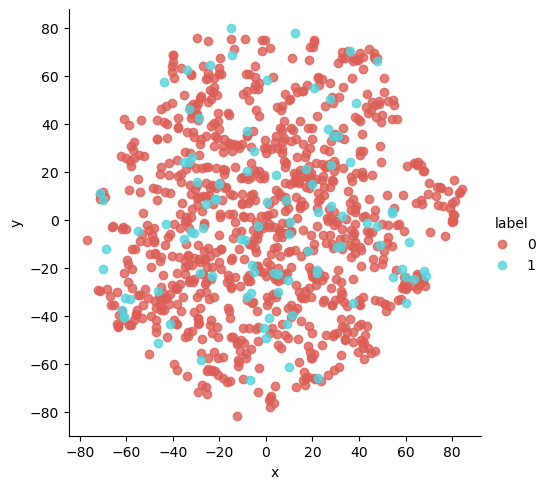

In [84]:
plt.figure()
# sb.lmplot('x', 'y', data=df, hue='label', fit_reg=False, palette="hls", size=6)
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)


## Apply TSNE on embeddings

In [132]:
tsne = TSNE(2)
projection = dict()
for k,v in embeddings.items():
    projection[k] = tsne.fit_transform(v)
    projection[k].shape

(1200, 2)

(1200, 2)

(1200, 2)

(1200, 2)

(1200, 2)

#### Layer 0 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

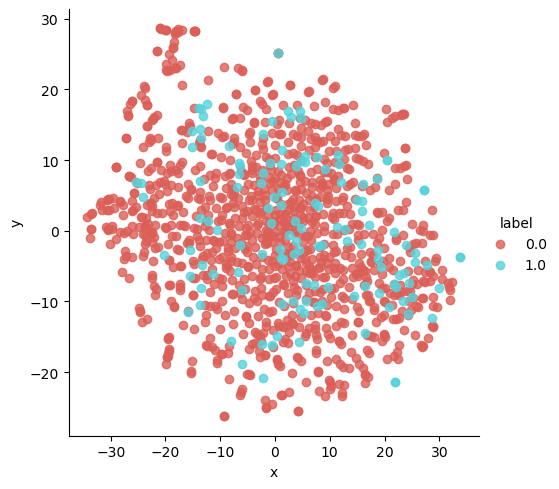

In [104]:
df = pd.DataFrame(dict(
    x=projection[0][:,0],
    y=projection[0][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y", hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 1 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

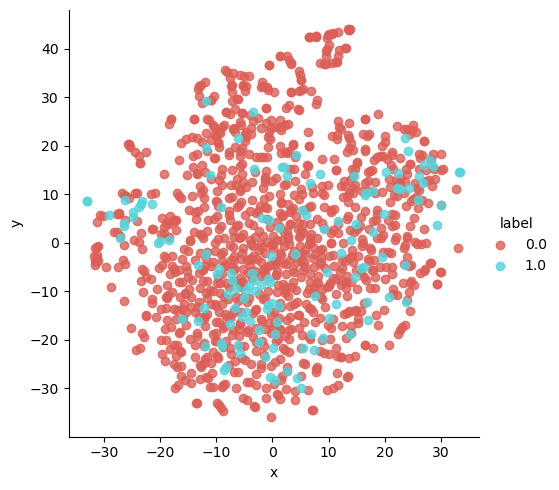

In [105]:
df = pd.DataFrame(dict(
    x=projection[1][:,0],
    y=projection[1][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 2 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

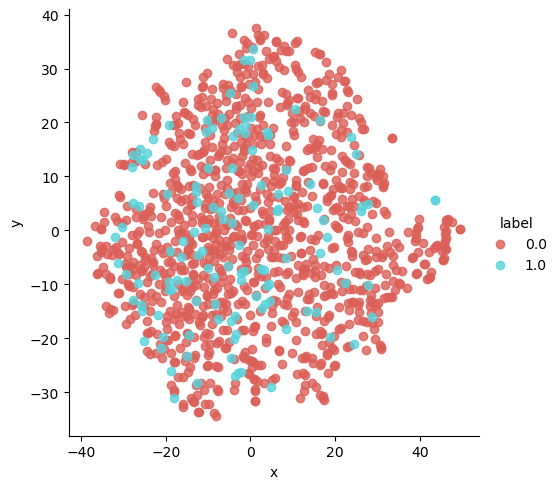

In [106]:
df = pd.DataFrame(dict(
    x=projection[2][:,0],
    y=projection[2][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 3 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

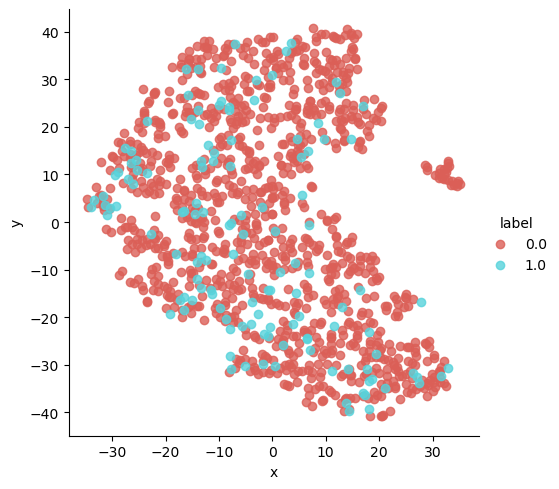

In [107]:
df = pd.DataFrame(dict(
    x=projection[3][:,0],
    y=projection[3][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

#### Layer 4 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

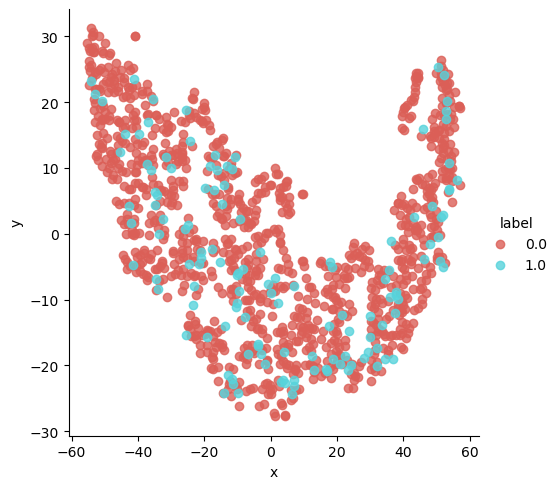

In [108]:
df = pd.DataFrame(dict(
    x=projection[4][:,0],
    y=projection[4][:,1],
    label=labels
))
plt.figure()
sb.lmplot( data=df, x ="x", y = "y",hue='label', fit_reg=False, palette="hls") #, size=6)

In [133]:
np.bincount(labels.astype(np.int64))

array([1071,  129])

(1200, 1, 1, 1, 1)

Text(0.5, 0, 'X Label')

Text(0.5, 0.5, 'Y Label')

Text(0.5, 0, 'Z Label')

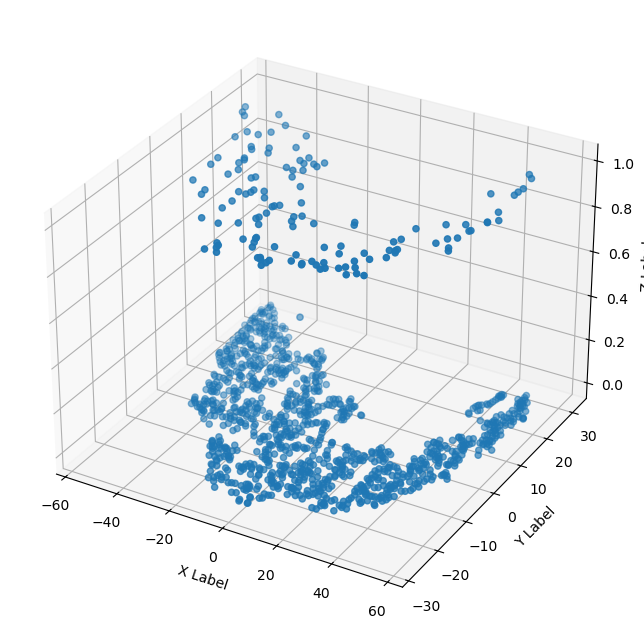

In [137]:
from matplotlib import cm
x=projection[4][:,0]
y=projection[4][:,1]
# z=projection[4][:,2]
label=np.expand_dims(labels,-1)
z = np.expand_dims(z,-1)
z.shape

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
# Plot the 3D surface
# ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
# ax.plot_trisurf(x, y, z, linewidth=0 , )
# surf = ax.plot_surface(x, y, label, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(x, y, label)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
ax.view_init(elev=45.)

plt.show()